**THE PROJECT WILL PURPOSE TO USE MACHINE LEARNING TO MAKE THE BIN SMART BY INTELLIGENTLY DETECTING LEVEL OF WASTE IN THE BIN AND THEREAFTER CONTACT THE SERVER MOTOR TO AUTOMATICALLY EMPTY THE BIN**

Machine learning is simply the ability of a computer to find patterns in data
The dataset is assumed to be the waste collection records of the bin that was done manually and recorded every day.

## Importing some of the necessary libraries

In [1]:
#basic libs
import pandas as pd
import numpy as np
#visualization libs
import matplotlib.pyplot as plt
import seaborn as sns
#to make graphs be rendered in the backend of matplotlib
%matplotlib inline
#to avoid unneccessary warning messages such as deprecation warnings from the libraries
import warnings
warnings.filterwarnings('ignore')

In [2]:
#conda update --all

## Load data into a pandas data frame

In [3]:
#read data into a frame
waste = pd.read_csv('MyBin_waste_records.csv')

## Exploratory Data Analysis

### (1).Understanding the data structure

#### (a).Overall data structure

In [4]:
#what are the features/attributes of our data
waste.columns
#we have 3 indepedent variables and a depedent variable 'TOTAL'

Index(['DATE', 'MONTH', 'TYPE', 'TOTAL (IN TONS)'], dtype='object')

In [5]:
#what data types are our attributes
waste.dtypes
#We have just one numeric attribute

DATE                object
MONTH               object
TYPE                object
TOTAL (IN TONS)    float64
dtype: object

In [6]:
#lets see about the shape
waste.shape
#we have over 1000 records of waste collection

(1140, 4)

In [7]:
#lets now take a view of the first 20 rows of our data
waste.head(20)
#all our attributes actually contains categorical data and one numerical(TOTAL)
#In my own opinion the day and month values in the'DATE' column wont be significant to us in this form,so we can 
#truncate the rest of it and remain with just YEAR which is atleast more significant,we will do this in EDA stage

DATE     MONTH             TYPE  TOTAL (IN TONS)
0   05/31/2012       May  Sidewalk Debris              0.0
1   12/31/2014  December    Misc. Garbage             66.0
2   05/31/2014       May  Misc. Recycling              3.0
3   03/31/2013     March  Misc. Recycling              6.0
4   03/31/2017     March   Asphalt Debris              0.0
5   10/31/2013   October   Asphalt Debris           5000.0
6   10/31/2016   October       Yard Waste            900.0
7   03/31/2015     March   Recycled Tires             12.0
8   06/30/2014      June    Misc. Garbage            226.0
9   01/31/2017   January       Yard Waste           1000.0
10  12/31/2017  December      Bottle Bill            317.0
11  01/31/2017   January      Bottle Bill            317.0
12  11/30/2016  November      Bottle Bill            317.0
13  03/31/2016     March  Sidewalk Debris              0.0
14  03/31/2014     March      Scrap Metal            336.0
15  02/28/2016  February    Misc. Garbage           1026.0
16  07/31/2011      July     Curb Garbage           9070.0
17  07/31/2017      July   Asphalt Debris              0.0
18  03/31/2015     March        Haz Waste              0.0
19  05/31/2015       May  Misc. Recycling              2.0

In [8]:
#get general data info
waste.info()
#says we have some null values in the column total,we will have to deal with this later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             1140 non-null   object 
 1   MONTH            1140 non-null   object 
 2   TYPE             1140 non-null   object 
 3   TOTAL (IN TONS)  1139 non-null   float64
dtypes: float64(1), object(3)
memory usage: 35.8+ KB


#### (b).Numerical attributes

In [9]:
#For now the only present numerical attribute is waste weight in tons which is our target variable
numerical=waste.select_dtypes(exclude='object')

In [10]:
#we can view its statistical summary
numerical.describe()
#the statistical summary shows that the values are skewed since over 50% are only 45 tons while the max is 12000 plus

TOTAL (IN TONS)
count      1139.000000
mean       1200.950834
std        2468.112134
min           0.000000
25%           0.000000
50%          45.000000
75%        1000.000000
max       12594.000000

#### (c).Categorical attributes

In [11]:
# select the categorical predictors
categoricals = waste.select_dtypes(include='object')

In [12]:
#lets get useful summary about the values in this attributes
categoricals.describe().transpose()
#there are 95 unique days when wastes were recorded,out of those days ,day 05/31/2012 is the most frequent
#you can see that Sidewalk Debris type of waste is most common ,is recorded atleast once in a month.

count unique              top freq
DATE   1140     95       05/31/2012   12
MONTH  1140     12              May   96
TYPE   1140     12  Sidewalk Debris   95

### (2).Exploring the data

#### (a).numerical attributes

##### (i).Target

In [13]:
#we only have one numerical attribute which is the target,lets just reselect it
target = waste[['TOTAL (IN TONS)']]

In [14]:
#Confirm its selected
target.columns

Index(['TOTAL (IN TONS)'], dtype='object')

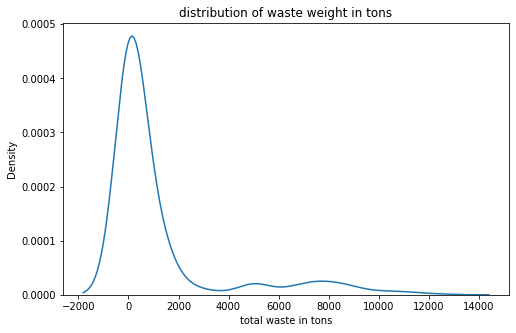

In [15]:
#lets see the distribution of its values
fig = plt.figure(figsize=(8,5))
sns.distplot(target,hist=False)
plt.title('distribution of waste weight in tons')
plt.xlabel('total waste in tons')
plt.show()
#distribution plot shows that the values in 'TOTAL (IN TONS)' are skewed to the right,solving this won't have 
#any impact on the performance of the model since it contains the values to be predicted

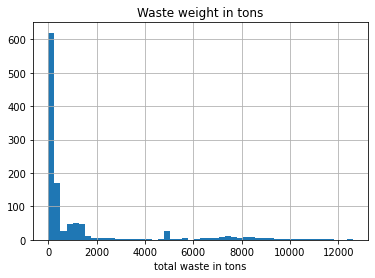

In [16]:
#Lets see more on distribution via histplot
waste.hist(column='TOTAL (IN TONS)',bins=50)
plt.title('Waste weight in tons')
plt.xlabel('total waste in tons')
plt.show()

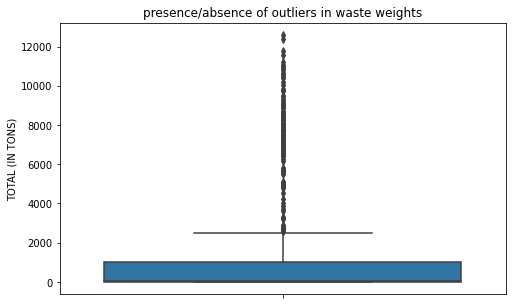

In [17]:
#lets see about presence of outliers in the weight records
target = waste[['TOTAL (IN TONS)']].values
fig = plt.figure(figsize=(8,5))
sns.boxplot(y=target)
plt.title('presence/absence of outliers in waste weights')
plt.ylabel('TOTAL (IN TONS)')
plt.show()
#We have many outliers for weights ranging from 3000 to 12000 and above

##### (ii).Predictors

HERE WE WILL MODIFY THE PREDICTOR VARIABLE DATE TO BE YEAR SINCE DATE IN THAT FORMAT IS NOT THAT SIGNIFICANT,THEREFORE WE WILL HAVE A NEW NUMERICAL ATTRIBUTE CALLED YEAR AND NOW EXPLORE IT AS A NUMERICAL PREDICTOR.

In [18]:
#Inititally
waste.head()

DATE     MONTH             TYPE  TOTAL (IN TONS)
0  05/31/2012       May  Sidewalk Debris              0.0
1  12/31/2014  December    Misc. Garbage             66.0
2  05/31/2014       May  Misc. Recycling              3.0
3  03/31/2013     March  Misc. Recycling              6.0
4  03/31/2017     March   Asphalt Debris              0.0

In [19]:
#Let's define a function to make the date column to be years  since it is not significant in that format.
#The new Date will now be a numerical #predictor

waste.head()
def clean_date(value):
    value = value[6:]
    return int(value)
waste['DATE']=waste['DATE'].apply(clean_date)
#WHAT THIS FUNCTION HAS DONE IS THAT IT HAS TRUNCATED THE DAY AND MONTH PART OF THE STRING DATE 

In [20]:
#So we have modified the column date to be YEAR,we can rename it to YEAR and drop column DATE
waste['DATE']=waste.rename(columns={'DATE':'YEAR'},inplace=True)
waste=waste.drop('DATE',axis=1)
waste.head()

YEAR     MONTH             TYPE  TOTAL (IN TONS)
0  2012       May  Sidewalk Debris              0.0
1  2014  December    Misc. Garbage             66.0
2  2014       May  Misc. Recycling              3.0
3  2013     March  Misc. Recycling              6.0
4  2017     March   Asphalt Debris              0.0

In [21]:
#Lets see the data types of our attributes now,we have two numerical and two categorical
waste.dtypes

YEAR                 int64
MONTH               object
TYPE                object
TOTAL (IN TONS)    float64
dtype: object

Lets now explore on this new numerical attribute that we generated from date

In [22]:
#Select it
numericals = waste.select_dtypes(include='int64')

In [23]:
#confirm
numericals.head()

YEAR
0  2012
1  2014
2  2014
3  2013
4  2017

In [24]:
#How many unique years do we have
waste['YEAR'].unique()
#We have records from year 2011 to 2018(8yrs)

array([2012, 2014, 2013, 2017, 2016, 2015, 2011, 2018], dtype=int64)

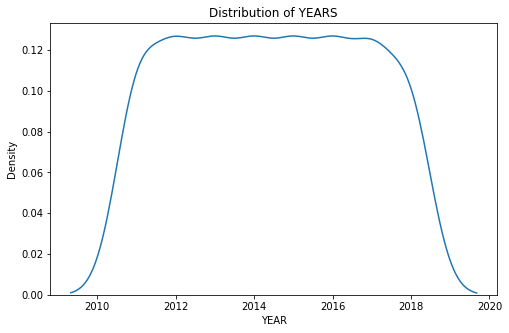

In [25]:
#let's see the distribution of recorded data over Years
fig=plt.figure(figsize=(8,5))
sns.distplot(numericals,hist=False)
plt.xlabel('YEAR')
plt.title('Distribution of YEARS')
plt.show()
#from 2010 to 2012 the number of records has been increasing but from 2018 to 2020 those who were recording this waste records
#started decreasing the rate at which they were recording.They stoped recording in 2020b

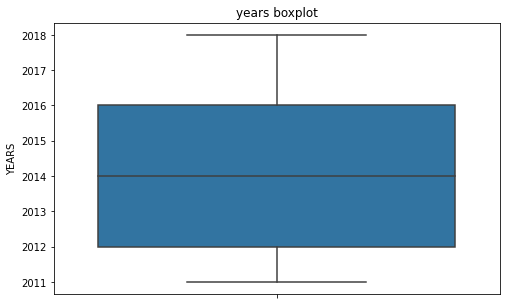

In [26]:
#Do we have outliers in this YEAR feature
fig=plt.figure(figsize=(8,5))
sns.boxplot(y=waste['YEAR'])
plt.title('years boxplot')
plt.ylabel('YEARS')
plt.show()
#We actually don't have outliers with this feature,it seems a good predictor!

In [27]:
#Is it correlated with our target variable TOTAL WASTE?
corr=waste.corr()
corr['TOTAL (IN TONS)']
#it has a negative correlation(though weak) with waste amount,meaning with time the amount of waste being recorded dropped.
#This could probably mean people have adopted better ways to handle waste and probably reuse some used products.

YEAR              -0.053552
TOTAL (IN TONS)    1.000000
Name: TOTAL (IN TONS), dtype: float64

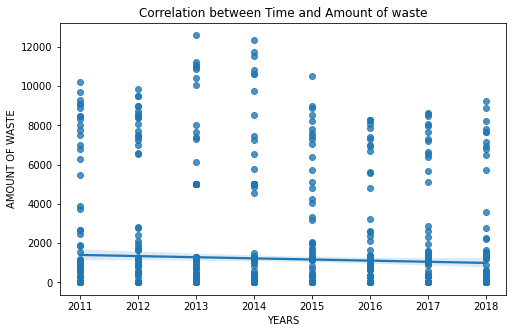

In [28]:
fig=plt.figure(figsize=(8,5))
sns.regplot(y=waste['TOTAL (IN TONS)'],x=waste['YEAR'])
plt.title('Correlation between Time and Amount of waste')
plt.xlabel('YEARS')
plt.ylabel('AMOUNT OF WASTE')
plt.show()
# A regression line confirms to us that time is weakly negatively correlated with weight of waste
#Therefore there is a weak negative correlation between time and amount of waste

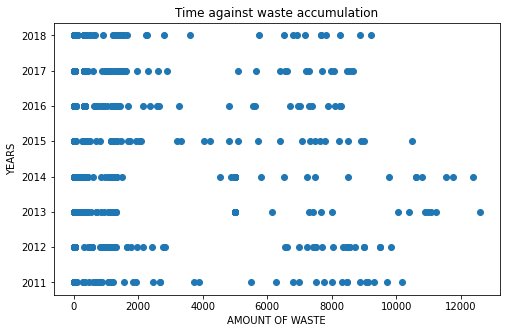

In [29]:
#Lets use a scatter plot investigate the relationship between time and the total wste
fig=plt.figure(figsize=(8,5))
plt.scatter(x=waste['TOTAL (IN TONS)'],y=waste['YEAR'])
plt.title('Time against waste accumulation')
plt.ylabel('YEARS')
plt.xlabel('AMOUNT OF WASTE')
plt.show()
#the highest amount of waste was recorded in 2013

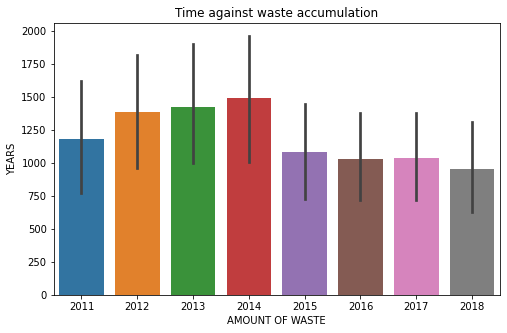

In [30]:
fig=plt.figure(figsize=(8,5))
sns.barplot(y=waste['TOTAL (IN TONS)'],x=waste['YEAR'])
plt.title('Time against waste accumulation')
plt.ylabel('YEARS')
plt.xlabel('AMOUNT OF WASTE')
plt.show()
#A bar plot tells us that in 2014 high amounts of waste in total was recorded

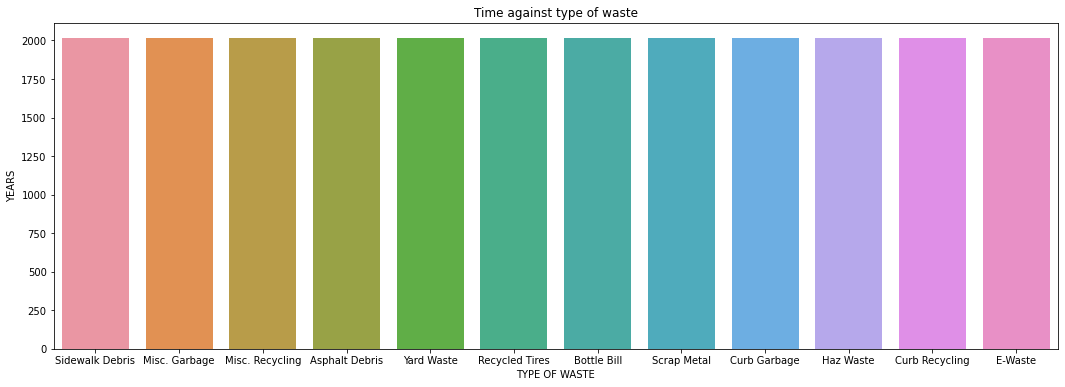

In [31]:
#What about time and type of waste
fig=plt.figure(figsize=(18,6))
sns.barplot(x=waste['TYPE'],y=waste['YEAR'])
plt.title('Time against type of waste')
plt.ylabel('YEARS')
plt.xlabel('TYPE OF WASTE')
plt.show()
#We can see that in every year all the types of waste were represented

#### (b).Categorical attributes

##### (i).Predictors

In [32]:
# isolate them
cate = waste.select_dtypes(include='object')

In [33]:
#These are the columns,we only have two categorical predictors since we converted DATE into numerical YEAR
cate.columns

Index(['MONTH', 'TYPE'], dtype='object')

Text(0.5, 1.0, 'Time in months against waste accumulation weight in tons')

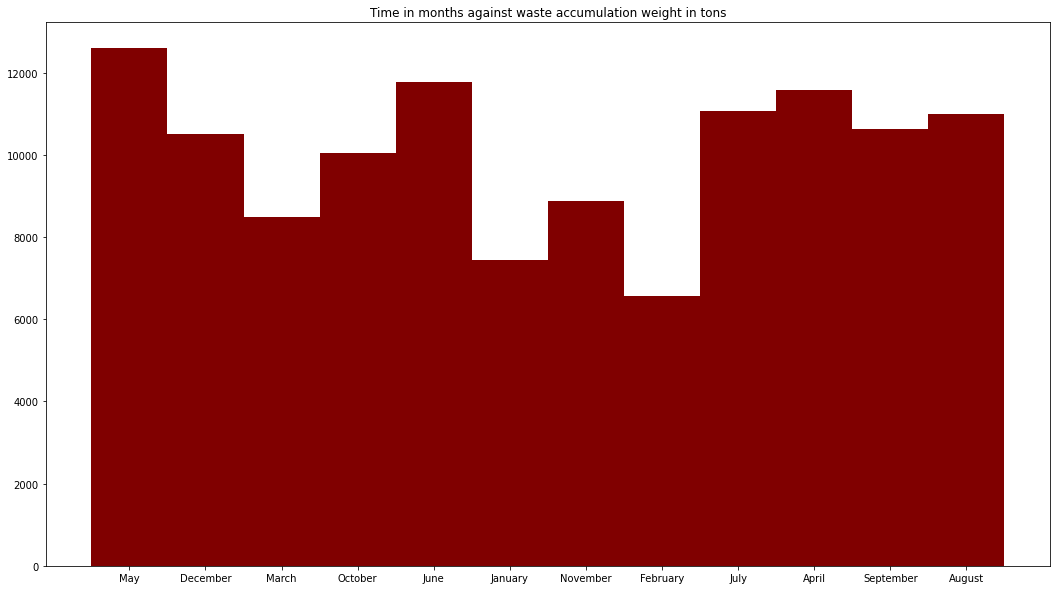

In [34]:
#How does time in months relate with the weight of wastes
fig = plt.figure(figsize=(18,10))
plt.bar(waste['MONTH'],waste['TOTAL (IN TONS)'],width=1,color='maroon')
plt.title('Time in months against waste accumulation weight in tons')
#We can see that in the month of May highest amount of waste was recorded,while in February least waste amount was recorded.

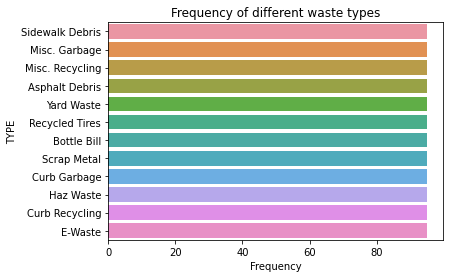

In [35]:
#How are waste types distributed
sns.countplot(y=waste['TYPE'])
plt.title('Frequency of different waste types')
plt.xlabel('Frequency')
plt.show()
#The graph says that the number of times each type appears in the data are all equal,we will prove this in a moment

In [36]:
#Lets prove
waste['TYPE'].value_counts()
#Sure they are,scrap metal appears 95 times just like all other types of wastes.

Sidewalk Debris    95
Misc. Garbage      95
Misc. Recycling    95
Asphalt Debris     95
Yard Waste         95
Recycled Tires     95
Bottle Bill        95
Scrap Metal        95
Curb Garbage       95
Haz Waste          95
Curb Recycling     95
E-Waste            95
Name: TYPE, dtype: int64

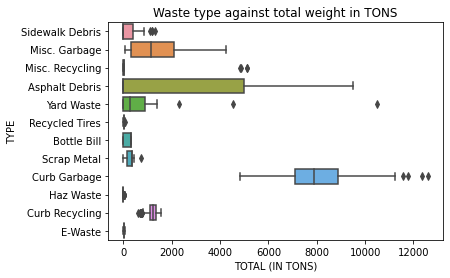

In [37]:
#How do type of waste relate with weight in tons of the total wastes accumulation
sns.boxplot(y=waste['TYPE'],x=waste['TOTAL (IN TONS)'])
plt.title('Waste type against total weight in TONS')
plt.show()
#We see that the weight of waste type Asphalt Debris is the highest in total while E-Waste weight is the least

*We have gained enough of the insights in our data and lets jump into the preprocessing stage and clean our data for machine learning model.*

### (3).Preprocessing the data

Data preprocessing is one of the most tedious time consuming stages in the development of a machine learning model.

In [38]:
import sys
!{sys.executable} -m pip install scikit-learn

In [39]:
#lets import the preprocessing library from module scikitlearn
from sklearn import preprocessing

#### (a).categorical attributes

##### (i).predictors

In [40]:
#check for null values
waste[['MONTH','TYPE']].isnull().sum()
#seems no nulls for both cat  atrributes

MONTH    0
TYPE     0
dtype: int64

Transformers to handle categorical attributes

In [41]:
#Lets use transformers to encode cat variables,Label encoding is a technique used to convert categorical data to numeric
#This is important because most machine learning algorithms only takes in numeric data
le_mon =preprocessing.LabelEncoder()
waste['MONTH']=le_mon.fit_transform(waste['MONTH'])

le_ty = preprocessing.LabelEncoder()
waste['TYPE']=le_ty.fit_transform(waste['TYPE'])

waste['TYPE']
waste['MONTH']

0        8
1        2
2        8
3        7
4        7
        ..
1135     9
1136    10
1137     3
1138     5
1139     9
Name: MONTH, Length: 1140, dtype: int32

Categorical attributes are now label encoded 

#### (b).numerical attributes

##### (i).Clean target variable 

In [42]:
#Checking for missing values
waste[['TOTAL (IN TONS)']].isnull().sum()
#It has 1 missing value

TOTAL (IN TONS)    1
dtype: int64

In [43]:
#Solve missing value
waste['TOTAL (IN TONS)'] =waste['TOTAL (IN TONS)'].fillna(waste['TOTAL (IN TONS)'].mode()[0])

In [44]:
#confirm
waste['TOTAL (IN TONS)'].isnull().sum()

0

NB:It's not necessary to normalize the output/target variable

##### (ii)Clean numerical predictor and normalize it

In [45]:
#We have one numerical predictor YEAR,
waste['YEAR']

0       2012
1       2014
2       2014
3       2013
4       2017
        ... 
1135    2018
1136    2018
1137    2011
1138    2018
1139    2018
Name: YEAR, Length: 1140, dtype: int64

In [46]:
#check for nulls
waste['YEAR'].isnull().sum()
#no nulls

0

In [47]:
#Normalize it
waste[['YEAR']]=preprocessing.normalize(waste[['YEAR']])

#### (c).Separate target and predictors

In [48]:
#Separate predictors from target 
X=waste.drop(['TOTAL (IN TONS)'],axis=1)
y=waste['TOTAL (IN TONS)']

*Done cleaning data let us move on to creating models*

### (4).Creating the model

We will create and train two regression algorithms,Linear Regression and a Non-Linear regression (applied a polynomial transform).We will split our data into two portions (training data and testing data) and reserve a portion for testing our data.Testing the model using data that is different from training data will show how best the model performs in an out of sample data.This helps increase out of sample accuracy.We will then pick the model that performs better on this type of data.

In [49]:
#importing the libraries for splitting data and creating model instances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#### (a).Split data

In [50]:
#split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2)
#We will train our model with 90% of the data that we have then use the remaining 10% for testing.The reason why I choose to 
#use this large amount on training is to make the model learn the pattern better now that we only 
#have a small dataset with fewer features
#Shape of training set
print('Shape training set X:',X_train.shape)
print('Shape training set y:',y_train.shape)

#Shape of testing set
print('Shape testing set X:',X_test.shape)
print('Shape testing set y:',y_test.shape)

Shape training set X: (1026, 3)
Shape training set y: (1026,)
Shape testing set X: (114, 3)
Shape testing set y: (114,)


#### (b).Linear Regression

Lets train and evaluate our first algorithm

##### (i).Train

In [51]:
#Create an instance of the model and store it in the variable LR
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

##### (ii).Predicting

In [52]:
#Perform the prediction
yhat = LR.predict(X_test)
yhat[0:5]

array([1592.64054731, 1612.67769198,  263.50915931, 1879.39450935,
         -3.20765805])

##### (iii).Evaluating

In [53]:
#Import the necessary in sample evaluation libraries
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#Get the model Accuracy using R-Squared
score = r2_score(y_test,yhat)
print('R2 Accuracy score using test data is',score*100,'%')

#Get the model accuracy using mean squared error
score = mean_squared_error(y_test,yhat)
print('mean_squared_error Accuracy score using test data is',score)
#NB for a good performing model mean_squared_error should be as small as possible
#the smaller it is the more accurate the model is

#THIS MODEL IS PERFORMING POORLY WITH AN OUT OF SAMPLE ACCURACY OF 13%

R2 Accuracy score using test data is 13.96610816324111 %
mean_squared_error Accuracy score using test data is 5121578.968169812


#### (c).Non-linear Regression (applied polynomial transform)

Lets train and evaluate our second algorithm

##### (i).Training

In [54]:
#Note polynomial feature transform is just for trying to make the non-linear regression line fit more 
#data points,thats why we use it together with the Linear regression model

polynomial = PolynomialFeatures(degree=12) #have used a higher degree to increase the accuracy of the model,however increasing it further might reduce the accuracy
PF = polynomial.fit_transform(X_train)
PF
#Train the linear regression model with X data that is transformed using polynomial feature 
#transform to make it a Non-Linear regression model
NR = LinearRegression()
NR.fit(PF,y_train)


LinearRegression()

##### (ii).Predicting

In [55]:
#Transform the data to be predicted first using the polynormial feature
X_transformed = polynomial.transform(X_test)
#Perform prediction
yhat = NR.predict(X_transformed)
yhat[0]

282.4841349055205

##### (iii).Evaluating

In [56]:
#Get the model Accuracy using R-Squared
score2 = r2_score(y_test,yhat)
print('R2 Accuracy score using test data is',score2*100,'%')

#Get the model accuracy using mean squared error
score2 = mean_squared_error(y_test,yhat)
print('mean_squared_error Accuracy score using test data is',score)
#NON-LINEAR REGRESSION MODEL IS PERFORMING BETTER THAN LINEAR REGRESSION MODEL

R2 Accuracy score using test data is 85.21463129366107 %
mean_squared_error Accuracy score using test data is 5121578.968169812


##### (iv).Save the model that you've chosen

We will go for non-linear regression model because it has a better out of sample accuracy of roughly (84%) compared to linear regression with only 13%. 

In [57]:
import pickle
#Save model,encoders,and polynomial feature transform
saved_data = {'model':NR,'le_mon':le_mon,'le_ty':le_ty,'poly':polynomial}
with open('chosen_model.pkl','wb') as file:
    pickle.dump(saved_data,file)


In [58]:
#Load model
def load_model():
    with open('chosen_model.pkl','rb') as file:
        load_data=pickle.load(file)
    return load_data

data = load_model()    
model = data["model"]
mon_encoder = data["le_mon"]
ty_encoder = data["le_ty"]
polynom = data["poly"]
#Test the saved model if its working
yhat=model.predict(X_transformed)
yhat[0]


282.4841349055205

Remember we want our model to be able to estimate the level of waste in the bin based on the waste accumulation behaviour of a certain bin.If the estimated value of the amount of waste is present in the bin then the app communicates to the server motor to empty the bin.

**WE HAVE SUCCESSFULLY TRAINED OUR MODEL AND NOW WE NEED TO PUT IT INTO PRODUCTION,TO DO THIS WE WILL USE VS CODE (CODE EDITOR) AND PYTHON LIBRARY CALLED STREAMLIT TO DESIGN THE UI,THEREFORE THE CODE FOR BUILDING THE UI MIGHT NOT BE PRESENT IN THIS NOTEBOOK**

### (5).Building the UI of the model

We will use python's library streamlit to build the user interface of the model.To save on time because streamlit does not require much coding and doesnt require prior knowledge of css,html and other web frameworks.Here in this section I will just export the code that I have used to create the UI from VS CODE.It therefore can't be executed from here in this notebook. 

**Below is the code that generated this model's UI.However it's not executable here in the notebook. I used VS code to run the streamlit app. <br>**
**Streamlit is an open source python library that can build a UI for various purposes.**

In [59]:
#Import the necessary libraries
#pip install "scikit-learn==0.19.0"
import streamlit as st
import pickle
import pandas as pd
from PIL import Image
import time
from sklearn import *

#Load the model
def load_model():
    with open('chosen_model.pkl','rb') as file:
        load_data=pickle.load(file)
    return load_data

load_data = load_model()
model = load_data["model"]
mon_encoder = load_data["le_mon"]
ty_encoder = load_data["le_ty"]
polynom = load_data["poly"]

#This is for the title
st.title('IN-HOUSE SMART DUSTBIN CLIENT APP')


#Welcoming the user
"""Welcome and feel free to use this app to check the level of the waste in the dustbin """

#Here am going to attach a photo

#User data
st.header('Enter the day,month and the bin you want to detect the waste level ')

#Note


#Store the input 'MONTH' selected by the user and tell them what they have choosen
month=('May','December', 'March','October', 'June', 'January',
        'November', 'February', 'July', 'April', 'September', 'August')

chosen_month=st.selectbox('Select the month of the year',month)

#Store the input 'DAY' entered by the user and tell them what they have choosen
day = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30)

chosen_day = st.selectbox('Select the day',day)

#Store the input 'WASTE' that is contained in the bin
waste= {"My Bin" : 'Yard Waste'}


chosen_type=st.selectbox('Select the bin you want to monitor',waste)
st.write('You currently have just one bin:',chosen_type)
st.write('NB: We can keep track of more than one bins,you can always add more bins to this system')

#What is contained in the bin
for chosen_type,value in waste.items():
    answer = value

 #Make a dataframe using the user input data
input_data = {'MONTH':chosen_month,'DAY':chosen_day,'BIN':answer}
input_df = pd.DataFrame(input_data,index=[0])

#Show the user what they have entered
st.header('You chose')
st.table(input_df)

#Output
ok = st.button("MONITOR")
if ok:
#CLEANING USER INPUT DATA
    Z = input_df[['DAY','MONTH','BIN']]
    Z['MONTH'] = mon_encoder.transform(Z['MONTH'])
    Z['BIN'] = ty_encoder.transform(Z['BIN'])
    Z[['DAY']] = preprocessing.normalize(Z[['DAY']])
    Z = polynom.fit_transform(Z)

#Contacting the cloud 
    waste_total = model.predict(Z)

#This if statement is to inform the managing personnel more about the level of waste

    if(waste_total[0]<=100):
          st.markdown(f"The garbage level is at [**{waste_total[0]:.2f} TONS**] mark.It is still a quarter full")
    elif(waste_total[0]>100 and waste_total[0]<=400):
          st.markdown(f"The garbage level is at [**{waste_total[0]:.2f} TONS**] mark.It is halfway full ")
    else:
        st.markdown(f"The garbage level is at [**{waste_total[0]:.2f} TONS**] mark.The garbage is full!.No need to worry I am taking care of this in a moment")
        st.write("""*Contacting the server motor to empty the bin......*""")
        time.sleep(10)
        empty = waste_total[0]-waste_total[0]
        st.subheader(f"The bin was successfully emptied, the garbage level is now at [*{empty}*] TONS")

2022-04-25 10:30:34.645 
  command:

    streamlit run D:\Anaconda_2\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
